# Import 

In [1]:
import settings
FT_EMBEDDING_PATH = '../Embedding/cc.fa.300.bin'

import fasttext 
import hazm
import pandas as pd
import pickle
import numpy as np
import gensim


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Embedding, Dropout
from tensorflow.keras.layers import  LSTM, Bidirectional,GRU

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import categorical_accuracy ,AUC
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.utils import plot_model


import matplotlib.pyplot as plot

D:\Apps\Anaconda3\envs\tf_2\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# Load Pretrained Embedding (Optional- Check Later)
We prefer to use pretrained persian fasttext embedding since it is pretrained on a large WikiPedia corpus and can better represent word embeddings.

- First of all download the pretrained embeddng and save it to the ../Embedding directory
- Then change the EMB_SIZE in the settings.py file accordingly(any embedding size you downloaded)

In [2]:
'''
ft_embedding = fasttext.load_model(FT_EMBEDDING_PATH)
len(ft_embedding.words)
'''

'\nft_embedding = fasttext.load_model(FT_EMBEDDING_PATH)\nlen(ft_embedding.words)\n'

# Prepare input

## Load data

In [2]:
def load_data(data_name):
    data = pd.read_csv(settings.DATA_DIR+data_name+'.csv', index_col=None,  encoding="utf-8")
    x , y= np.asarray(data['comment']), np.asarray(data['sentiment'])
    return x,y
def get_tokenized_data(data_name):
    x , y= load_data(data_name)
    tokenized_x =  [hazm.word_tokenize(sent) for sent in x]
    return tokenized_x,y


x_test , y_test= load_data('test')
x_train , y_train= load_data('train')
x_val , y_val= load_data('valid')
len(x_test), len(x_train), len(x_val)


(556, 4503, 501)

## Train Tokenizer

In [3]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
# Save tokenizer
with open(settings.TOKENIZER_PATH, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Train FastText  word embedding

We decided to use fast text because it better handles OOV by means of subwords.
- We are using embedding size of 100 since our corpus is small so that it cannot properly update large embedding matrix. 
- Window size is 5 ( deafault )
- We train the embedding for 10 epochs


In [4]:
from gensim.models import FastText
def train_fasttext_emb(corpus):
    sentences = [[word for word in hazm.word_tokenize(text)] for text in corpus]

    emb_model = FastText(sentences, vector_size  = settings.EMB_SIZE , min_count=1)
    emb_model.build_vocab(sentences)
    emb_model.train(sentences, total_examples=len(corpus), epochs=10)  # train
    emb_model.save(settings.EMBEDDING_PATH)
    return emb_model

# Train the embedding
emb_model = train_fasttext_emb(x_train)

# load the pretrained model
#emb_model = FastText.load(EMBEDDING_PATH)

print(emb_model.wv.most_similar('خوب'))

[('خوبش', 0.9867684245109558), ('خوبن', 0.9866349101066589), ('خوبی', 0.970436155796051), ('خوبه', 0.9524381160736084), ('خوبیست', 0.9466794729232788), ('بخوبی', 0.9434263706207275), ('عالی', 0.9415867924690247), ('خوش', 0.9355658292770386), ('عالی٢', 0.9286019802093506), ('عالی٤', 0.9276235103607178)]


In [5]:
# extract fasttext learned embedding weights to feed to our model
def get_emb_matrix(emb_model_):
    embedding_matrix = np.random.random((len(tokenizer.word_index)+1, emb_model_.vector_size))
    pas = 0
    for word,i in tokenizer.word_index.items():
        try:
            embedding_matrix[i] = emb_model_.wv[word]
        except:
            print(word)
            pas+=1
    return embedding_matrix

embedding_matrix = get_emb_matrix(emb_model)

## Prepare data

Here we tokenize and pad sequence comments of our input data and convert class labels to categorical format.

In [6]:
def prepare_data(x , y ):
    sequence_docs = tokenizer.texts_to_sequences(x)
    # pad data to Maximum Sequence Length
    pad_sequence_docs = pad_sequences(sequence_docs, maxlen=settings.SEQUENCE_LEN, padding='post')
    # Prepare labels for categorical prediction
    categorical_y = to_categorical(y, settings.CLASS_NUM)
    return pad_sequence_docs, categorical_y


train_pad_sequence, train_categorical_y = prepare_data(x_train , y_train)
val_pad_sequence, val_categorical_y = prepare_data(x_val , y_val)
test_pad_sequence, test_categorical_y = prepare_data(x_test , y_test)
    

## calculate class weight

In [7]:
#from sklearn.utils import class_weight
import sklearn
import numpy as np
class_w = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(y_train) , y_train)
class_w_dic = {}
for i in range(len(class_w)):
    class_w_dic[i] = class_w[i]
class_w_dic

D:\Apps\Anaconda3\envs\tf_2\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[-2 -1  0  1  2], y=[ 0  1 -1 ...  0  1  2] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


{0: 40.93636363636364,
 1: 2.1649038461538463,
 2: 0.46160943106099434,
 3: 0.6848669201520913,
 4: 1.1271589486858573}

At first we tried to use the calculated class weights for training, but we realized that the model doesn't assign any comments to the classes 2,3,4. It is because the weight of these three classes are much less than the first two classes. So, we decided to manually set class weights such that weight of minorites are more than wight of majorites but not that much different.

In [8]:
class_w_dic={0:40,1:20, 2:10 , 3:10, 4:10 }

# Model-BiGRU

We are using two layer bidirectional GRU with a dense layer on top of them. We choose to make a small model since we have a small corpus to train our model and a high capacity model will overfit the data ( or cannot learn at all)

For finetuning we did the following experiment
- Compared BiGRU vs BiLSTM  --> BiGRU works better
- Compared different class_weights
- Finetuning Embedding size :{100, 200, 300} 
- Finetuning learning rate : {0.01, 0.05, 0.001} --> 0.001 works better
- Finetuning batch size:     {16, 64, 128} -->128 works better
- Finetuning size of each layer
- Finetuning dropout
- Fix pretrained Embedding vs train the embedding during training the model 
- Added l2 norm to the dense layers --> mproved performance


In [28]:

temp_model = Sequential()
temp_model.add(Embedding(embedding_matrix.shape[0], embedding_matrix.shape[1], weights=[embedding_matrix], trainable=False))
temp_model.add(Bidirectional(GRU(100, return_sequences=True, name='lstm_layer')))
temp_model.add(Dropout(0.2))
temp_model.add(Dense(50, activation="relu", kernel_regularizer='l2'))
temp_model.add(Bidirectional(GRU(50)))
temp_model.add(Dropout(0.1))
temp_model.add(Dense(5, activation='softmax', kernel_regularizer='l2'))



In [29]:
#Config
METRICS = [
    categorical_accuracy,
    tf.keras.metrics.AUC(name='auc'),
    #tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]
opt = tf.keras.optimizers.Adam(learning_rate=0.005)
temp_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=[METRICS])

temp_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         767600    
_________________________________________________________________
bidirectional_4 (Bidirection (None, None, 200)         121200    
_________________________________________________________________
dropout_4 (Dropout)          (None, None, 200)         0         
_________________________________________________________________
dense_4 (Dense)              (None, None, 50)          10050     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100)               30600     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                

### Train

In [32]:
batch_size = 256
epochs = 20
history = temp_model.fit(train_pad_sequence, train_categorical_y,
                         batch_size=batch_size, epochs=epochs, 
                         class_weight=class_w_dic,
                         validation_data=(val_pad_sequence, val_categorical_y) , 
                         shuffle=True)

Epoch 1/20
18/18 [==============================] - 20s 1s/step - loss: 16.1954 - categorical_accuracy: 0.6600 - auc: 0.8993 - val_loss: 1.6885 - val_categorical_accuracy: 0.6008 - val_auc: 0.8820
Epoch 2/20
18/18 [==============================] - 20s 1s/step - loss: 14.9031 - categorical_accuracy: 0.6860 - auc: 0.9144 - val_loss: 1.6589 - val_categorical_accuracy: 0.6347 - val_auc: 0.8894
Epoch 3/20
18/18 [==============================] - 20s 1s/step - loss: 14.0064 - categorical_accuracy: 0.7109 - auc: 0.9236 - val_loss: 1.6713 - val_categorical_accuracy: 0.6327 - val_auc: 0.8871
Epoch 4/20
18/18 [==============================] - 20s 1s/step - loss: 13.2245 - categorical_accuracy: 0.7306 - auc: 0.9296 - val_loss: 1.6747 - val_categorical_accuracy: 0.6267 - val_auc: 0.8865
Epoch 5/20
18/18 [==============================] - 21s 1s/step - loss: 12.5209 - categorical_accuracy: 0.7415 - auc: 0.9359 - val_loss: 1.7198 - val_categorical_accuracy: 0.6228 - val_auc: 0.8823
Epoch 6/20
18/1

In [123]:
batch_size = 128
epochs = 10
history = temp_model.fit(train_pad_sequence, train_categorical_y,
                         batch_size=batch_size, epochs=epochs, 
                         class_weight=class_w_dic,
                         validation_data=(val_pad_sequence, val_categorical_y) , 
                         shuffle=True)

Epoch 1/15
36/36 [==============================] - 21s 573ms/step - loss: 24.3746 - categorical_accuracy: 0.4348 - auc: 0.7757 - val_loss: 1.2516 - val_categorical_accuracy: 0.4850 - val_auc: 0.8236
Epoch 2/15
36/36 [==============================] - 18s 500ms/step - loss: 19.3437 - categorical_accuracy: 0.5456 - auc: 0.8512 - val_loss: 1.0001 - val_categorical_accuracy: 0.5968 - val_auc: 0.8733
Epoch 3/15
36/36 [==============================] - 19s 528ms/step - loss: 14.9928 - categorical_accuracy: 0.6613 - auc: 0.9030 - val_loss: 1.0617 - val_categorical_accuracy: 0.5808 - val_auc: 0.8687
Epoch 4/15
36/36 [==============================] - 19s 535ms/step - loss: 10.6068 - categorical_accuracy: 0.7548 - auc: 0.9449 - val_loss: 1.2819 - val_categorical_accuracy: 0.5848 - val_auc: 0.8517
Epoch 5/15
36/36 [==============================] - 19s 541ms/step - loss: 7.4341 - categorical_accuracy: 0.8250 - auc: 0.9695 - val_loss: 1.5807 - val_categorical_accuracy: 0.6088 - val_auc: 0.8350
E

<function matplotlib.pyplot.show(close=None, block=None)>

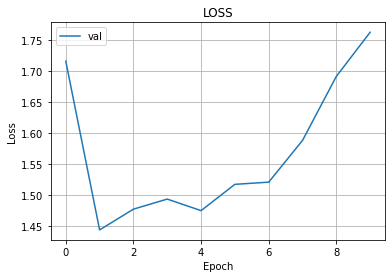

In [31]:
import matplotlib.pyplot as plt
#plt.plot(history.history['loss'] , label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("LOSS")
plt.show

### Evaluate

In [17]:
print("Evaluate on test data")
results = temp_model.evaluate(test_pad_sequence, test_categorical_y, batch_size=batch_size)
print("test loss:{loss}, test acc:{acc}, test auc: {auc}".format( loss = results[0],acc = results[1] ,auc=results[2] ))



Evaluate on test data
5/5 [==============================] - 0s 75ms/step - loss: 1.7551 - categorical_accuracy: 0.5935 - auc: 0.8633
test loss:1.7550904750823975, test acc:0.5935251712799072, test auc: 0.8633244037628174


### Prediction

In [18]:
# on new data using `predict`
print("Generate predictions for 3 samples")
predictions = temp_model.predict(test_pad_sequence[:3])
print("predictions shape:", predictions.shape)
preds = np.argmax(predictions, axis = 1)
x_test[:3] , preds

Generate predictions for 3 samples
predictions shape: (3, 5)


(array(['متاسفانه از نظر اپل انتقال و رد و بدل کردن اطلاعات و همچنین نصب برنامه با قیمت پایین همواره ممنوع است',
        'سامسونگ به کمک سنسور شتاب سنج بعضی کنترل های حرکتی جالب را برای این گوشی در نظر گرفته است',
        'خیلی عالیه بزودی از همین سایت می خرمش'], dtype=object),
 array([0, 0, 2], dtype=int64))

### ADD ML PIPELINE

### Save Model

In [20]:
import os

if not os.path.exists(settings.MODEL_DIR):
    os.makedirs(settings.MODEL_DIR)
temp_model.save(
    settings.MODEL_DIR+'temp_model.h5',
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None,
)

In [21]:
from tensorflow.keras.models import load_model
# deletes the existing model
#del temp_model  
model = load_model(settings.MODEL_DIR+'temp_model.h5')

In [23]:
print("Evaluate on test data")
results = model.evaluate(test_pad_sequence, test_categorical_y, batch_size=batch_size)
print("test loss, test acc:", results)
predictions = model.predict(test_pad_sequence)

Evaluate on test data
5/5 [==============================] - 0s 86ms/step - loss: 1.7551 - categorical_accuracy: 0.5935 - auc: 0.8633
test loss, test acc: [1.7550904750823975, 0.5935251712799072, 0.8633244037628174]


# Confusion Matrix

In [24]:
y_true = np.argmax(test_categorical_y, axis = 1)
y_pred = np.argmax(predictions, axis = 1)
class_names = np.array(range(5))

In [25]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm =confusion_matrix(y_true, y_pred)


In [26]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    import itertools  
    """

    This function prints and plots the confusion matrix.

    Normalization can be applied by setting `normalize=True`.

    """

    plt.figure(figsize=(8,8))



    plt.imshow(cm, interpolation='nearest', cmap=cmap)

    plt.title(title)

    plt.colorbar()



    tick_marks = np.arange(len(classes))

    plt.xticks(tick_marks, classes, rotation=45)

    plt.yticks(tick_marks, classes)



    if normalize:

        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        cm = np.around(cm, decimals=2)

        cm[np.isnan(cm)] = 0.0

        print("Normalized confusion matrix")

    else:

        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):

        plt.text(j, i, cm[i, j],

                 horizontalalignment="center",

                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()

    plt.ylabel('True label')

    plt.xlabel('Predicted label')



Normalized confusion matrix


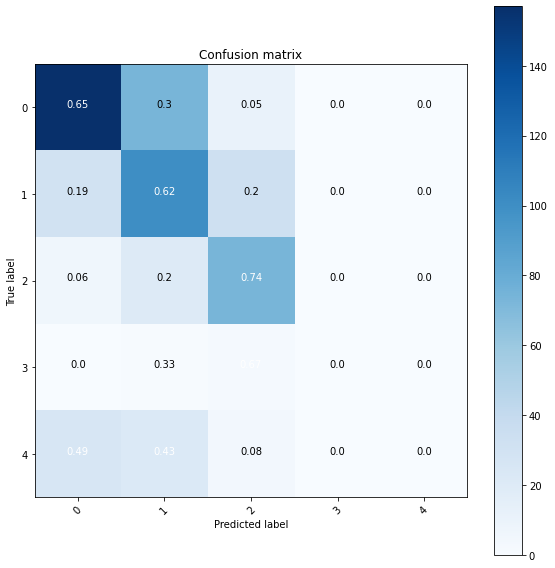

In [27]:
plot_confusion_matrix(cm, class_names)

Normalized confusion matrix


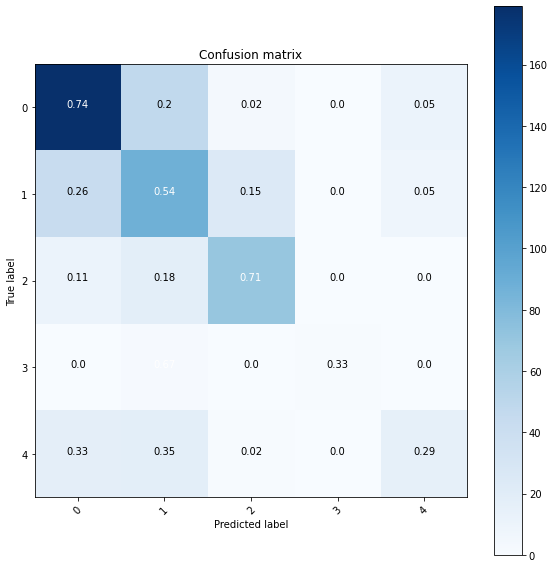

In [130]:
plot_confusion_matrix(cm, class_names)

Normalized confusion matrix


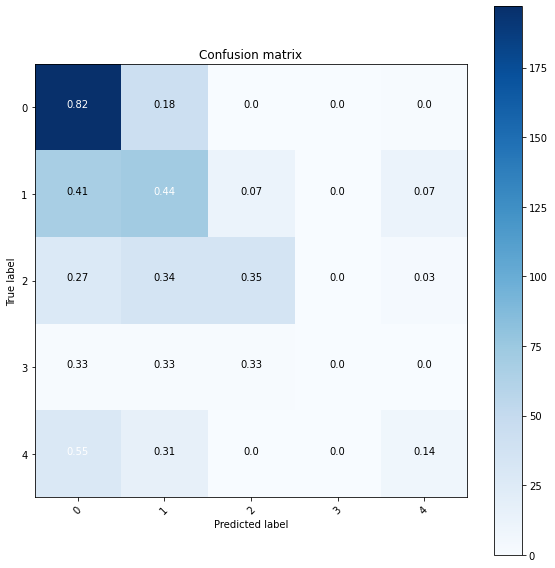

In [117]:
plot_confusion_matrix(cm, class_names)

Normalized confusion matrix


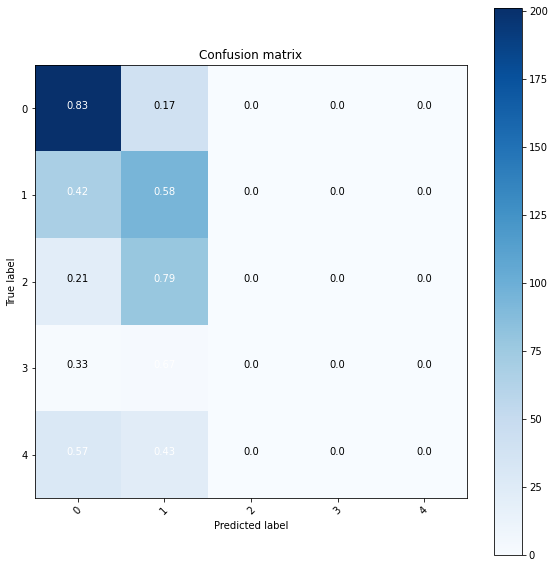

In [96]:
plot_confusion_matrix(cm, class_names)